In [41]:
#Importing the required libraries

In [42]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

#### Reading the image in BGR format and also converting it into grayscale

In [43]:
img=cv2.imread(r"D:\Classification\model\test_images\sh.jpg")

In [44]:
print(img) #In computers images are represented in the form of arrays
print(img.shape)           #This is a bgr or rgb image which is 3D

[[[175 180 178]
  [175 180 178]
  [175 180 178]
  ...
  [206 209 207]
  [206 209 207]
  [206 209 207]]

 [[176 181 179]
  [176 181 179]
  [176 181 179]
  ...
  [206 209 207]
  [206 209 207]
  [206 209 207]]

 [[176 181 179]
  [176 181 179]
  [176 181 179]
  ...
  [207 210 208]
  [207 210 208]
  [207 210 208]]

 ...

 [[189 194 193]
  [189 194 193]
  [189 194 193]
  ...
  [199 202 200]
  [199 202 200]
  [199 202 200]]

 [[188 193 192]
  [188 193 192]
  [188 193 192]
  ...
  [199 202 200]
  [199 202 200]
  [199 202 200]]

 [[188 193 192]
  [188 193 192]
  [188 193 192]
  ...
  [199 202 200]
  [199 202 200]
  [199 202 200]]]
(408, 612, 3)


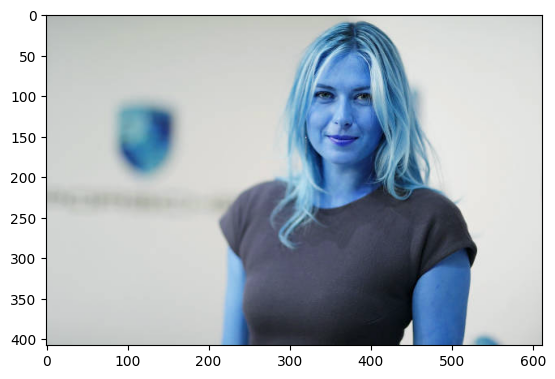

In [45]:
plt.imshow(img)

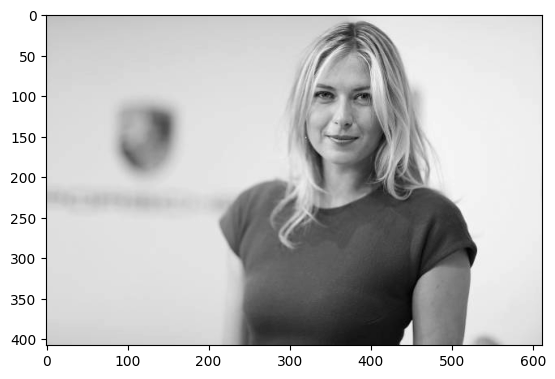

In [46]:
#Converting the image into grayscale image
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

In [47]:
print(gray) #2D

[[179 179 179 ... 208 208 208]
 [180 180 180 ... 208 208 208]
 [180 180 180 ... 209 209 209]
 ...
 [193 193 193 ... 201 201 201]
 [192 192 192 ... 201 201 201]
 [192 192 192 ... 201 201 201]]


In [48]:
print(gray.shape)

(408, 612)


## Using Haar Cascade

+ Haar Cascade is a machine learning-based approach used for object detection in images or videos. It was proposed by Paul Viola and Michael Jones in their paper titled "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. Haar Cascades are particularly effective for detecting objects that have well-defined features, such as faces, eyes, cars, and so on.
+ Haar features are simple rectangular patterns that can be used to describe objects. These features are like templates that are applied over the entire image at different scales and locations.(line and edge features)
  

### Detecting the face

In [49]:
face_cascade=cv2.CascadeClassifier(r"D:\Classification\model\opencv\haarcascades\haarcascade_frontalface_default.xml")
eye_cascade=cv2.CascadeClassifier(r"D:\Classification\model\opencv\haarcascades\haarcascade_eye.xml")

In [50]:
faces=face_cascade.detectMultiScale(gray,scaleFactor=1.1, minNeighbors=5)
#It is possible that there can be multiple faces in the image so faces[0] , faces[1] ,etc. can be used to detect them all

In [51]:
(x,y,w,h)=faces[0]
print(x,y,w,h) #x and y Coordinates and width and height of the face detected

303 53 128 128


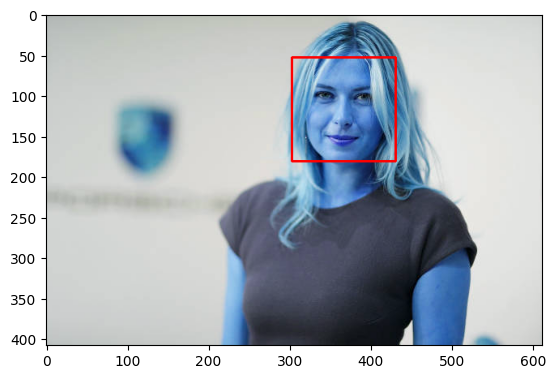

In [52]:
#Drawing recatnge around the detected face
face_img=cv2.rectangle(img,(x,y),(x+h,y+w),(255,0,0),2)
plt.imshow(face_img)

### Detecting the eyes

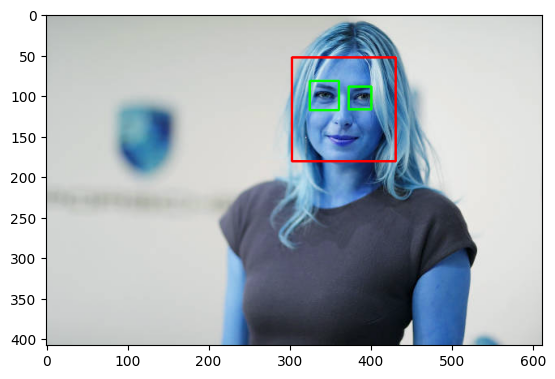

In [53]:
cv2.destroyAllWindows()
for (x, y, w, h) in faces:
    # Draw rectangle around the face
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # Get the region of interest
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
    eyes = eye_cascade.detectMultiScale(roi_gray)
    
    # Iterate over detected eyes and draw rectangles
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

plt.figure()
plt.imshow(face_img,cmap="gray")
plt.show()
